In [163]:
# connect google drive
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [164]:
# the folder I use
!ls /content/gdrive/My\ Drive/IFT6135/datasets

Finite_diff.png  loss.npy  loss_plot.png  mnist.pkl.gz	mnist.pkl.npy  torch


In [0]:
path="/content/gdrive/My Drive/IFT6135/datasets/"

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function

np.random.seed(666)

In [167]:
import torch
print(torch.cuda.current_device())

print(torch.cuda.device(0))

print(torch.cuda.device_count())

print(torch.cuda.get_device_name(0))


0
1
Tesla K80


In [168]:
"""
Load data and preprocessing(one_hot y_labels)
"""
def one_hot_labels(labels,dim=10):
    """put labels to one_hot"""
    labels=labels.reshape(-1)
    index=np.arange(labels.shape[0])
    label=np.zeros([labels.shape[0],dim])
    label[index,labels]=1
    return label


## data preprocessing

data=np.load("/content/gdrive/My Drive/IFT6135/datasets/mnist.pkl.npy",encoding = 'latin1')

train_X=data[0][0]
train_y=data[0][1]
valid_X=data[1][0]
valid_y=data[1][1]
test_X=data[2][0]
test_y=data[2][1]

train_Y=one_hot_labels(train_y)

valid_Y=one_hot_labels(valid_y)

test_Y=one_hot_labels(test_y)

print("\n",train_X.shape,train_Y.shape,"\n",valid_X.shape,valid_Y.shape,"\n",test_X.shape,test_Y.shape)


 (50000, 784) (50000, 10) 
 (10000, 784) (10000, 10) 
 (10000, 784) (10000, 10)


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils as utils

import torchvision
import torchvision.transforms

In [170]:
"""original code does not support train_validation_test split"""
# mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# mnist_train = torchvision.datasets.MNIST(root=path+'/torch/data', train=True, transform=mnist_transforms, download=True)
# # mnist_valid
# mnist_test = torchvision.datasets.MNIST(root=path+'/torch/data', train=False, transform=mnist_transforms, download=True)

# print(type(mnist_train))
# print(mnist_train.shape)

'original code does not support train_validation_test split'

In [0]:
tensor_train_X = torch.stack([torch.Tensor(i.reshape(1,28,28)) for i in train_X]) 
tensor_train_y = torch.stack([torch.Tensor([i]) for i in train_y])


tensor_valid_X = torch.stack([torch.Tensor(i.reshape(1,28,28)) for i in valid_X]) 
tensor_valid_y = torch.stack([torch.Tensor([i]) for i in valid_y])


tensor_test_X = torch.stack([torch.Tensor(i.reshape(1,28,28)) for i in test_X]) 
tensor_test_y = torch.stack([torch.Tensor([i]) for i in test_y])



train_torch = utils.data.TensorDataset(tensor_train_X,tensor_train_y) # create your datset
train_loader = utils.data.DataLoader(train_torch,batch_size=64, shuffle=True, num_workers=1) # create your dataloader





valid_torch = utils.data.TensorDataset(tensor_valid_X,tensor_valid_y) # create your datset
valid_loader = utils.data.DataLoader(valid_torch,batch_size=64, shuffle=True, num_workers=1) # create your dataloader



test_torch = utils.data.TensorDataset(tensor_test_X,tensor_test_y) # create your datset
test_loader = utils.data.DataLoader(test_torch,batch_size=64, shuffle=True, num_workers=1) # create your dataloader





In [172]:

cuda_available=torch.cuda.is_available()
print("Cuda available?  ",cuda_available)

Cuda available?   True


In [0]:



class conv_NN(nn.Module):
    def __init__(self):
        
        super(conv_NN,self).__init__()
        
        # input_dim=data_format[0]
        # output_dim=data_format[1]
        # self.dims=[input_dim]+list(hidden_dims)+[output_dim]
        # self.n_hidden = n_hidden
        # self.initialize_weights(initial=initial)
        # self.activations=activations
        self.conv=nn.Sequential(
            ## Layer 1
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),

            ## Layer 2
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),

            # Layer 3
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),

            # Layer 4
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2)
        )
        # Logistic Regression
        self.clf=nn.Linear(128,10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())
        

In [0]:
clf = conv_NN()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.SGD(clf.parameters(),lr=1e-1)
criterion=nn.CrossEntropyLoss()
# nn.LogSoftmax()+nn.NLLLoss()

In [193]:
training_err=[]
valid_err=[]
for epoch in range(10):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        targets=targets.flatten().type(torch.long)

        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss=loss.item()
        losses.append(loss)
        
    av_loss=np.mean(losses)
    # training_losses.append(av_loss)
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        targets=targets.flatten().type(torch.long)

        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    
    
    av_acc=correct.item()/total
    training_err.append(1-av_acc)
    

    
    print('Epoch : %d --- Training Losses: %.3f --- Training Accuracy: %.3f ---  Training Error: %.3f' % (epoch,av_loss,av_acc,1-av_acc))
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    
    
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        targets=targets.flatten().type(torch.long)

        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    
    valid_acc=correct.item()/total
    valid_err.append(1-valid_acc)
    
    
    print('Epoch : %d --- Validation Acc : %.3f --- Validation Error : %.3f' % (epoch, valid_acc,1-valid_acc))
    
    
    print('-------------------------------------------------------------------------------------------------------')
    clf.train()

Epoch : 0 --- Training Losses: 0.689 --- Training Accuracy: 0.918 ---  Training Error: 0.082
Epoch : 0 --- Validation Acc : 0.942 --- Validation Error : 0.058
-------------------------------------------------------------------------------------------------------
Epoch : 1 --- Training Losses: 0.199 --- Training Accuracy: 0.939 ---  Training Error: 0.061
Epoch : 1 --- Validation Acc : 0.980 --- Validation Error : 0.020
-------------------------------------------------------------------------------------------------------
Epoch : 2 --- Training Losses: 0.155 --- Training Accuracy: 0.899 ---  Training Error: 0.101
Epoch : 2 --- Validation Acc : 0.947 --- Validation Error : 0.053
-------------------------------------------------------------------------------------------------------
Epoch : 3 --- Training Losses: 0.132 --- Training Accuracy: 0.955 ---  Training Error: 0.045
Epoch : 3 --- Validation Acc : 0.977 --- Validation Error : 0.023
----------------------------------------------------

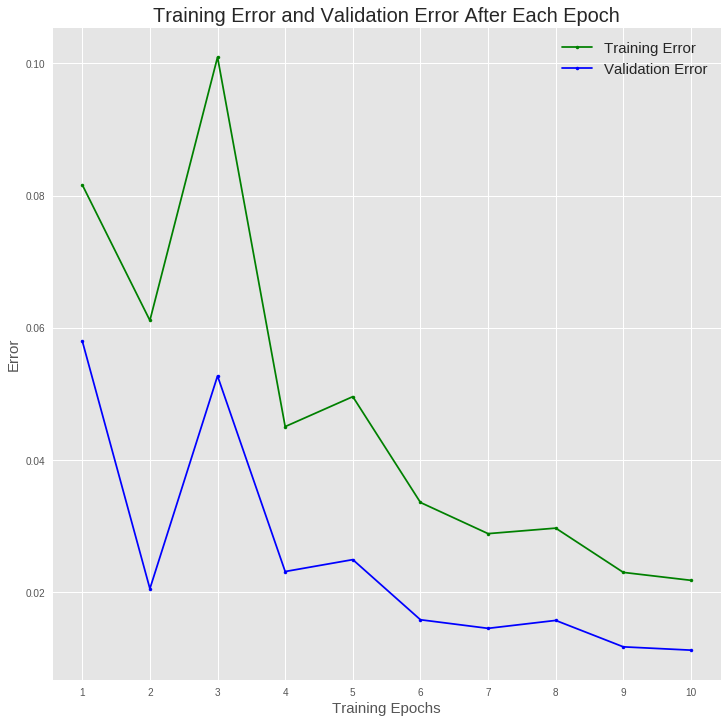

In [196]:
epochs=np.arange(len(valid_err))



plt.style.use('ggplot')
plt.figure(figsize=[12,12])
plt.plot(epochs,training_err,"g.-",label="Training Error")
plt.plot(epochs,valid_err,"b.-",label="Validation Error")
plt.xlabel("Training Epochs",fontsize=15)
plt.ylabel("Error",fontsize=15)
plt.xticks(epochs,[i+1 for i in epochs])
plt.legend(loc="upper right",fontsize=15)
plt.title("Training Error and Validation Error After Each Epoch",fontsize=20)
plt.savefig(path+"CNN_Error.png")
plt.show()


In [0]:
class NN(object):
    
    def __init__(self,hidden_dims=(666,666),data_format=[784,10],n_hidden=2,mode='train',datapath=None,model_path=None,initial="Glorot",activations=["sigmoid","sigmoid","softmax"],mini_batch=1,random_state=666):
        """hidden_dims: the size of hidden layers
        data_format:  the feature dims and the label dims(one_hot)
        n_hidden: the number of hidden layer
        mode: mode of the model
        initial: the method of weight initialization
                ["Zero","Normal","Glorot"]
        activations: a list of the type of activation function 
                            ("ReLU","Sigmoid","Softmax")
        mini_batch: the size of mini_batch (default: 1 == SGD)
        
        
        
        Not using sigmoid may cause softmax (exp overflow)
        
        """
        
        
        np.random.seed(random_state)
        
#         self.data=datapath[0]
#         self.label=datapath[1]
        input_dim=data_format[0]
        output_dim=data_format[1]
        self.dims=[input_dim]+list(hidden_dims)+[output_dim]
        self.n_hidden = n_hidden
        self.initialize_weights(initial=initial)
        self.activations=activations
        


    def initialize_weights(self,initial="Glorot"):
    # def initialize_weights(n_hidden,dims,initial):

        # dim=[input_dim,hidden_dims,output_dim]
        # weights not include the bias 
        n_hidden=self.n_hidden
        dims=self.dims
        weights=[]
        biases=[]
        if len(dims)!=n_hidden+2:
            raise ValueError("The length of dims does not match the num of hidden layer") 
        if initial=="Zero":
            for l in range(n_hidden+1):
                weights.append(np.matrix(np.zeros([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
        elif initial=="Normal":
            for l in range(n_hidden+1):
                weights.append(np.matrix(np.random.normal(0,1,dims[l]*dims[l+1]).reshape([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
        elif initial=='Glorot':
            for l in range(n_hidden+1):
                d=np.sqrt(6/(dims[l]+dims[l+1]))
                weights.append(np.matrix(np.random.uniform(-d,d,dims[l]*dims[l+1]).reshape([dims[l],dims[l+1]])))
                biases.append(np.matrix(np.zeros([1,dims[l+1]])))
#         elif initial=="He":
#             for l in range(n_hidden+1):
#                 weights.append(np.matrix(np.random.randn(dims[l],dims[l+1]) / np.sqrt(dims[l]/2)))
#                 biases.append(np.matrix(np.zeros([1,dims[l+1]])))

        self.weights=weights
        self.biases=biases





    def forward(self,input_):
        # here input is the data point
        # input: n x m
        
#         input_=input_.reshape(-1,self.dims[0])
        cache=dict()
        
        input_=np.matrix(input_).reshape(-1,self.dims[0])
        mb=input_.shape[0]
        hidden_pre=[]
        hidden_act=[]
        hidden_act.append(input_)
        for i in range(self.n_hidden+1):
#             print(i)
#             print("---")
#             print(input_.shape)
#             print(self.weights[i].shape)
#             print(input_.shape,self.weights[i].shape,self.biases[i].shape)
            output=np.dot(input_,self.weights[i])+np.dot(np.ones([input_.shape[0],1]),self.biases[i])
#             print(output.shape,"pre")
            hidden_pre.append(output)
            output=self.activation(output,act=self.activations[i])
#             print(output.shape,"activation")
            hidden_act.append(output)
            input_=output
#             print("========")
        cache["hidden_pre"]=hidden_pre
        cache["hidden_act"]=hidden_act
        output=output.reshape(-1,self.dims[-1])
        return output,cache


    def activation(self,input,act="ReLU"):
        act=act.lower()
        if act=="relu":
            return self.ReLU(input)
        elif act=="sigmoid":
            return self.sigmoid(input)
        elif act=="softmax":
            return self.softmax(input)
        else:
            raise ValueError("act should be the name of an activation function")

    def softmax(self,X):
        """ with stable setting in case of overflow"""
        e = np.exp(X - np.dot(np.max(X,axis=1),np.ones([1,X.shape[1]])))
        return np.multiply(e,1/np.dot(np.sum(e,axis=1),np.ones([1,X.shape[1]])))


    def sigmoid(self,input):
        index=-input > np.log(np.finfo(np.float).max)   
          
        result=1/(1+np.exp(-input))
        result[index]=0
        
        return result

    def ReLU(self,input):
        input[np.where(input<0)]=0
        return input

    
    
    def loss(self,prediction,label):
        # cross-entropy
        # self
        prediction=np.matrix(prediction)
        label=np.matrix(label)
        prediction[np.where(prediction<=0)]=prediction[np.where(prediction<=0)]+0.0000001
        loss=np.nan_to_num(np.multiply(-label,np.log(prediction)))
        loss=np.sum(loss,axis=1)
        return loss
    

    def derivative(self,input,func,labels=0):
        """if func='crossentropy, labels are require'"""
        func=func.lower()
        func=func.replace(" ","").replace("_","").replace("-","")
        if func=="sigmoid":
            input=np.matrix(input)
            return np.multiply(self.sigmoid(input),(1-self.sigmoid(input)))
        elif func=="relu":
            return (input>0).astype(np.float)
    #     elif func=="softmax":
    #         p=self.softmax(input)
    #         grad_matrix=np.diag(p)-np.dot(p.reshape(-1,1),p.reshape(1,-1))
    #         return np.sum(grad_matrix,axis=0)
    #     elif func=="crossentropy":
    #         labels=labels.reshape(-1)
    #         return input-labels
        else:
            raise ValueError("Please set the function type")


    def backward(self,cache,labels):
        """grad_w,grad_b are with the opposite order"""

        grad_w=[]
        grad_b=[]
        mini_batch=cache["hidden_act"][-1].shape[0] # mini_batch=n
        gradient=cache["hidden_act"][-1]-labels # n x 10
        for i in range(self.n_hidden+1):
            l=self.n_hidden-i
            # activation function
            # pre-activation function
#             print(cache["hidden_act"][l].reshape(mini_batch,-1).transpose())
#             print(gradient.reshape(mini_batch,-1))
#             try:
            grad_w.append((np.dot(cache["hidden_act"][l].transpose(),gradient))/mini_batch)
#             except:
#                 print(cache["hidden_act"][l])
#                 print(gradient)
            b_g=gradient.copy()
            grad_b.append(np.mean(b_g,axis=0))
                
            # gradient update
            if l<=0:
                break
            gradient=np.dot(gradient,self.weights[l].transpose())
            gradient=np.multiply(np.array(gradient),np.array(self.derivative(cache["hidden_pre"][l-1],self.activations[l-1])))

        grads=dict()
        grads["weights"]=[grad_w[self.n_hidden-i] for i in range(self.n_hidden+1)]
        grads["biases"]=[grad_b[self.n_hidden-i] for i in range(self.n_hidden+1)]

        return grads






    def update(self,grads,learning_rate=0.1):
        for i in range(self.n_hidden+1):
            self.weights[i]=self.weights[i]-learning_rate*grads["weights"][i]
            self.biases[i]=self.biases[i]-learning_rate*grads["biases"][i]
        return None




    def train(self,data,labels,epochs=10,learning_rate=0.1,mini_batch=1):
        if labels.shape[1]!=self.dims[-1]:
            raise ValueError("the label format doesn't match the one hot format")
        
        data=np.matrix(data).reshape(-1,self.dims[0])
        labels=np.matrix(labels).reshape(-1,self.dims[-1])
        # set counters zeros
        grads=dict()
        grads["weights"]=[np.zeros(w.shape) for w in self.weights]
        grads["biases"]=[np.zeros(b.shape) for b in self.biases]
        #
        loss_epoch=[]
        batches=data.shape[0]//mini_batch
        acc_epoch=[]
        for epoch in range(epochs):
            for i in range(batches+1):
                if i==batches and data.shape[0]%mini_batch==0:
                    break
                
                X=data[i*mini_batch:np.min([i*mini_batch+mini_batch,data.shape[0]])]
                Y=labels[i*mini_batch:np.min([i*mini_batch+mini_batch,data.shape[0]])]
                prediction,cache=self.forward(X)
#                 print(prediction)
                loss=self.loss(prediction,Y)
                new_grads=self.backward(cache,Y)
                loss_mb=np.mean(loss,axis=0)[0,0]        
                
                print("loss=%f  ---- epoch: %d  mini_batch: %d "%(loss_mb,epoch,i),end="\r")
                self.update(new_grads,learning_rate)
                    # set counter zeros
            
            av_loss,acc=self.test(data,labels)
            loss_epoch.append(av_loss)
            acc_epoch.append(acc)
#             print("----------------------")
#             print("Average_loss=%f  acc=%f ---- epoch: %d"%(av_loss,acc,epoch),end="\n")          
#             print("----------------------")

        return [np.array(loss_epoch),np.array(acc_epoch)]





    def test(self,X,Y):
#         if Y.shape[1]!=self.dims[-1]:
#             raise ValueError("the label format doesn't match the one hot format")
#         for i in range(data.shape[0]):
#             X=data[i]
#             Y=labels[i]
        X=np.matrix(X).reshape(-1,self.dims[0])
        Y=np.matrix(Y).reshape(-1,self.dims[-1])
        prediction,cache=self.forward(X)
        loss=self.loss(prediction,Y)
        av_loss=np.mean(loss,axis=0)[0,0]
        acc=np.mean(np.argmax(prediction,axis=1)==np.argmax(Y,axis=1),axis=0)[0,0]


        return [av_loss,acc]

    
    def valid_gradient(self,X,Y,p=10,eps=1,base=0,base2=0):
        X=np.matrix(X)
        Y=np.matrix(Y)
        prediction,cache=self.forward(X)
        loss=self.loss(prediction,Y)
        grads=self.backward(cache,Y)
        true_grad=grads["weights"][0][base:(base+p),base2]
        
        true_grad=np.array(true_grad).flatten()
        estimate_grad=[]
        loss1=[]
        loss2=[]
        for i in range(p):
            pred_1,_=self.forward_eps(X,eps=eps,index=i+base,index2=base2)
            pred_2,_=self.forward_eps(X,eps=-eps,index=i+base,index2=base2)
            loss_1=self.loss(pred_1,Y)
            loss_2=self.loss(pred_2,Y)
            nabla=(loss_1-loss_2)/(2*eps)
            nabla=nabla[0,0]
            estimate_grad.append(nabla)
            loss1.append(loss_1)
            loss2.append(loss_2)
        estimate_grad=np.array(estimate_grad)
        loss1=np.array(loss1)
        loss2=np.array(loss2)
        return [true_grad,estimate_grad]
        
    def forward_eps(self,input_,eps,index,index2=0):
        # here input is the data point
        # input: m x 1
        cache=dict()
        


        hidden_pre=[]
        hidden_act=[]
        hidden_act.append(input_)
        weights=[i.copy() for i in self.weights]

        weights[0][index,index2]=weights[0][index,index2]+eps

        cache=dict()
        
        input_=np.matrix(input_).reshape(-1,self.dims[0])
        mb=input_.shape[0]

        for i in range(self.n_hidden+1):
#             print(i)
#             print("---")
#             print(input_.shape)
#             print(self.weights[i].shape)
#             print(input_.shape,self.weights[i].shape,self.biases[i].shape)
            output=np.dot(input_,weights[i])+np.dot(np.ones([input_.shape[0],1]),self.biases[i])
#             print(output.shape,"pre")
            hidden_pre.append(output)
            output=self.activation(output,act=self.activations[i])
#             print(output.shape,"activation")
            hidden_act.append(output)
            input_=output
#             print("========")
        cache["hidden_pre"]=hidden_pre
        cache["hidden_act"]=hidden_act
        output=np.matrix(output).reshape(-1,self.dims[-1])
        return output,cache


In [0]:
MLP2=NN(hidden_dims=(666, 666),initial="Glorot",activations=["ReLU","ReLU","softmax"])


In [187]:
MLP2_training_err=[]
MLP2_valid_err=[]
for epoch in range(10):

    # Train
    
    loss_,acc=MLP2.train(train_X,train_Y,epochs=1,mini_batch=64)

    av_loss=np.mean(loss_)
    av_acc=np.mean(acc)
    
    MLP2_training_err.append(1-av_acc)
    # training_losses.append(av_loss)
    


    
    print('Epoch : %d --- Training Losses: %.3f --- Training Accuracy: %.3f ---  Training Error: %.3f' % (epoch,av_loss,av_acc,1-av_acc))
    
    # Evaluate
    
    
    valid_loss,valid_acc=MLP2.test(test_X,test_Y)
    MLP2_valid_err.append(1-valid_acc)
    
    
    
    
    print('Epoch : %d --- Validation Acc : %.3f --- Validation Error : %.3f' % (epoch, valid_acc,1-valid_acc))
    
    
    print('-------------------------------------------------------------------------------------------------------')


Epoch : 0 --- Training Losses: 0.189 --- Training Accuracy: 0.944 ---  Training Error: 0.056
Epoch : 0 --- Validation Acc : 0.943 --- Validation Error : 0.057
-------------------------------------------------------------------------------------------------------
Epoch : 1 --- Training Losses: 0.116 --- Training Accuracy: 0.966 ---  Training Error: 0.034
Epoch : 1 --- Validation Acc : 0.961 --- Validation Error : 0.039
-------------------------------------------------------------------------------------------------------
Epoch : 2 --- Training Losses: 0.086 --- Training Accuracy: 0.975 ---  Training Error: 0.025
Epoch : 2 --- Validation Acc : 0.967 --- Validation Error : 0.033
-------------------------------------------------------------------------------------------------------
Epoch : 3 --- Training Losses: 0.065 --- Training Accuracy: 0.981 ---  Training Error: 0.019
Epoch : 3 --- Validation Acc : 0.970 --- Validation Error : 0.030
----------------------------------------------------

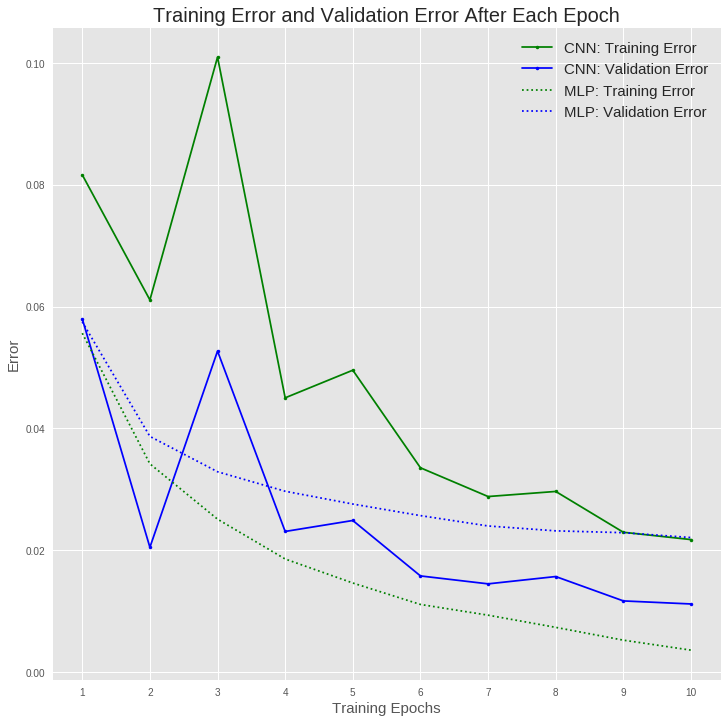

In [197]:
epochs=np.arange(len(valid_err))



plt.style.use('ggplot')
plt.figure(figsize=[12,12])
plt.plot(epochs,training_err,"g.-",label="CNN: Training Error")
plt.plot(epochs,valid_err,"b.-",label="CNN: Validation Error")
plt.plot(epochs,MLP2_training_err,"g:",label="MLP: Training Error")
plt.plot(epochs,MLP2_valid_err,"b:",label="MLP: Validation Error")

plt.xlabel("Training Epochs",fontsize=15)
plt.ylabel("Error",fontsize=15)
plt.xticks(epochs,[i+1 for i in epochs])
plt.legend(loc="upper right",fontsize=15)
plt.title("Training Error and Validation Error After Each Epoch",fontsize=20)
plt.savefig(path+"CNN_MLP_Error.png")
plt.show()


The MLP has lower Training Error but higher Validation Error.

The Training Error of CNN is higher than Validation Error.

